### A notebook for a Deep Q-Learning Re-inforcement Model for Executing Large Sell Orders in Digital Asset Markets

In [1]:
pip install numpy pandas matplotlib ccxt mplfinance scipy

     |████████████████████████████████| 12.4 MB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 4.5 MB 69.4 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 34.5 MB 67.8 MB/s eta 0:00:01
     |████████████████████████████████| 345 kB 96.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.6 MB 69.6 MB/s eta 0:00:01
     |████████████████████████████████| 308 kB 73.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 71.3 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 109.4 MB/s eta 0:00:01
     |████████████████████████████████| 288 kB 75.4 MB/s eta 0:00:01
     |████████████████████████████████| 240 kB 67.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


v2.10 was last version to support GPU on windows

In [ ]:
pip install "tensorflow<2.11"

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import ccxt
from datetime import date, datetime, time
import mplfinance as mpf
from collections import deque
import random
from scipy import stats 

#### Data Collection

In [4]:
# Parameter set up 

binance = ccxt.binance() # Initialises the binance class 
symbol = "BLUR/USDT"
timeframe = "5m"
start_time_training = date(2023, 11, 30)
end_time_testing = date(2023, 12, 29)

In [5]:
start_time_training = int(datetime.combine(start_time_training, datetime.min.time()).timestamp()*1000)
end_time_testing = int(datetime.combine(end_time_testing, datetime.min.time()).timestamp()*1000)

In [6]:
df_training = pd.DataFrame({"Time":[], "Open":[], "High":[], "Low":[], "Close":[], "Volume":[]})
df_testing = pd.DataFrame({"Time":[], "Open":[], "High":[], "Low":[], "Close":[], "Volume":[]})

In [7]:
ohlcv = []

while start_time_training < end_time_testing:
    data =  binance.fetch_ohlcv(symbol=symbol, timeframe=timeframe, since=start_time_training, limit=1000, params={"until": end_time_testing}) # paginates data till end of timeframe
     
    if data:
        ohlcv+=data
        start_time_training =  data[-1][0]
    else:
        break

In [8]:
df = pd.DataFrame(ohlcv, columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
df.head()

,Time,Open,High,Low,Close,Volume
0,1701302400000,0.5036,0.5045,0.5010,0.5021,159603.9
1,1701302700000,0.5021,0.5032,0.5010,0.5020,127153.6
2,1701303000000,0.5021,0.5038,0.4987,0.4998,194531.1
3,1701303300000,0.4997,0.4997,0.4954,0.4976,297601.0
4,1701303600000,0.4978,0.5000,0.4978,0.4999,257358.7


Data Cleaning

In [9]:
def data_duplicate_check(df):
    duplicates = df['Time'].duplicated(keep=False)
    df_duplicates = df[duplicates]
    num_duplicates = duplicates.sum()

    print(f'Number of duplicate entries: {num_duplicates}')
    print(df_duplicates)

data_duplicate_check(df=df)

Number of duplicate entries: 16
               Time    Open    High     Low   Close    Volume
999   1701602100000  0.5750  0.5756  0.5721  0.5739  170711.1
1000  1701602100000  0.5750  0.5756  0.5721  0.5739  170711.1
1999  1701901800000  0.5019  0.5030  0.5019  0.5022  154095.7
2000  1701901800000  0.5019  0.5030  0.5019  0.5022  154095.7
2999  1702201500000  0.5087  0.5123  0.5087  0.5107  468455.0
3000  1702201500000  0.5087  0.5123  0.5087  0.5107  468455.0
3999  1702501200000  0.4654  0.4659  0.4641  0.4643   83891.9
4000  1702501200000  0.4654  0.4659  0.4641  0.4643   83891.9
4999  1702800900000  0.4390  0.4404  0.4384  0.4394   86787.8
5000  1702800900000  0.4390  0.4404  0.4384  0.4394   86787.8
5999  1703100600000  0.5246  0.5275  0.5246  0.5251  200619.1
6000  1703100600000  0.5246  0.5275  0.5246  0.5251  200619.1
6999  1703400300000  0.5143  0.5148  0.5106  0.5113  171248.0
7000  1703400300000  0.5143  0.5148  0.5106  0.5113  171248.0
7999  1703700000000  0.5009  0.5035  0

In [10]:
df = df.drop_duplicates(keep="first")

In [11]:
data_duplicate_check(df=df)

Number of duplicate entries: 0
Empty DataFrame
Columns: [Time, Open, High, Low, Close, Volume]
Index: []


In [12]:
df["Time"] = pd.to_datetime(df["Time"], unit="ms")
df.set_index("Time", inplace=True)
df

,Open,High,Low,Close,Volume
Time,,,,,
2023-11-30 00:00:00,0.5036,0.5045,0.5010,0.5021,159603.9
2023-11-30 00:05:00,0.5021,0.5032,0.5010,0.5020,127153.6
2023-11-30 00:10:00,0.5021,0.5038,0.4987,0.4998,194531.1
2023-11-30 00:15:00,0.4997,0.4997,0.4954,0.4976,297601.0
2023-11-30 00:20:00,0.4978,0.5000,0.4978,0.4999,257358.7
...,...,...,...,...,...
2023-12-28 23:40:00,0.4866,0.4867,0.4858,0.4862,22681.3
2023-12-28 23:45:00,0.4864,0.4865,0.4850,0.4855,96102.6
2023-12-28 23:50:00,0.4854,0.4854,0.4826,0.4829,35659.5


Feature Engineering

$$ VWAP = \frac{\Sigma (Price \cdot Volume)}{\Sigma Volume} $$

In [13]:
df["Typical_Price"] = (df["High"] + df["Low"] + df["Close"]) / 3

df["TPV"] = df["Typical_Price"] * df["Volume"]

# We reset the VWAP each day so our cummulative sum is done for each day
df["Cumulative_TPV"] = df.groupby(df.index.date)["TPV"].cumsum()
df["Cumulative_Volume"] = df.groupby(df.index.date)["Volume"].cumsum()

df["VWAP"] = df["Cumulative_TPV"] / df["Cumulative_Volume"]
df["VWAP_std"] = df.groupby(df.index.date)["VWAP"].transform(lambda x: x.expanding().std())
df["VWAP_std"] = df["VWAP_std"]/4
df[["Open", "High", "Low", "Close", "Volume", "VWAP", "VWAP_std"]]

,Open,High,Low,Close,Volume,VWAP,VWAP_std
Time,,,,,,,
2023-11-30 00:00:00,0.5036,0.5045,0.5010,0.5021,159603.9,0.502533,NaN
2023-11-30 00:05:00,0.5021,0.5032,0.5010,0.5020,127153.6,0.502326,0.000037
2023-11-30 00:10:00,0.5021,0.5038,0.4987,0.4998,194531.1,0.501696,0.000109
2023-11-30 00:15:00,0.4997,0.4997,0.4954,0.4976,297601.0,0.500118,0.000273
2023-11-30 00:20:00,0.4978,0.5000,0.4978,0.4999,257358.7,0.499898,0.000309
...,...,...,...,...,...,...,...
2023-12-28 23:40:00,0.4866,0.4867,0.4858,0.4862,22681.3,0.497415,0.001144
2023-12-28 23:45:00,0.4864,0.4865,0.4850,0.4855,96102.6,0.497386,0.001147
2023-12-28 23:50:00,0.4854,0.4854,0.4826,0.4829,35659.5,0.497373,0.001149


In [14]:
df["EMA(5)"] =df["Close"].ewm(span=5, adjust=False).mean()
df

,Open,High,Low,Close,Volume,Typical_Price,TPV,Cumulative_TPV,Cumulative_Volume,VWAP,VWAP_std,EMA(5)
Time,,,,,,,,,,,,
2023-11-30 00:00:00,0.5036,0.5045,0.5010,0.5021,159603.9,0.502533,80206.279880,8.020628e+04,159603.9,0.502533,NaN,0.502100
2023-11-30 00:05:00,0.5021,0.5032,0.5010,0.5020,127153.6,0.502067,63839.584107,1.440459e+05,286757.5,0.502326,0.000037,0.502067
2023-11-30 00:10:00,0.5021,0.5038,0.4987,0.4998,194531.1,0.500767,97414.690510,2.414606e+05,481288.6,0.501696,0.000109,0.501311
2023-11-30 00:15:00,0.4997,0.4997,0.4954,0.4976,297601.0,0.497567,148076.337567,3.895369e+05,778889.6,0.500118,0.000273,0.500074
2023-11-30 00:20:00,0.4978,0.5000,0.4978,0.4999,257358.7,0.499233,128482.041663,5.180189e+05,1036248.3,0.499898,0.000309,0.500016
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28 23:40:00,0.4866,0.4867,0.4858,0.4862,22681.3,0.486233,11028.404103,1.909024e+07,38378892.6,0.497415,0.001144,0.485925
2023-12-28 23:45:00,0.4864,0.4865,0.4850,0.4855,96102.6,0.485667,46673.829400,1.913691e+07,38474995.2,0.497386,0.001147,0.485783
2023-12-28 23:50:00,0.4854,0.4854,0.4826,0.4829,35659.5,0.483633,17246.122850,1.915416e+07,38510654.7,0.497373,0.001149,0.484822


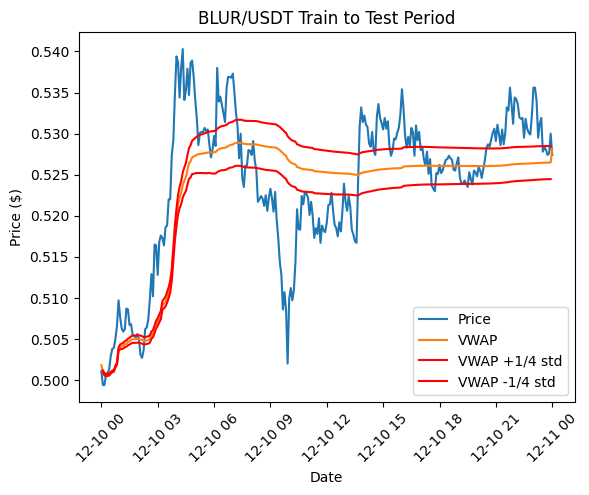

In [15]:
df.loc["2023-12-10 00:00:00":"2023-12-11 00:00:00"]
plt.plot(df.loc["2023-12-10 00:00:00":"2023-12-11 00:00:00"]["Close"], label="Price")
plt.plot(df.loc["2023-12-10 00:00:00":"2023-12-11 00:00:00"]["VWAP"], label="VWAP")
plt.plot(df.loc["2023-12-10 00:00:00":"2023-12-11 00:00:00"]["VWAP"]+df.loc["2023-12-10 00:00:00":"2023-12-11 00:00:00"]["VWAP_std"], label="VWAP +1/4 std", color="red")
plt.plot(df.loc["2023-12-10 00:00:00":"2023-12-11 00:00:00"]["VWAP"]-df.loc["2023-12-10 00:00:00":"2023-12-11 00:00:00"]["VWAP_std"], label="VWAP -1/4 std", color="red")
plt.xlabel("Date")
plt.xticks(rotation=45) 
plt.ylabel("Price ($)")
plt.title("BLUR/USDT Train to Test Period")
plt.legend()
plt.show()

In [16]:
df.head()


,Open,High,Low,Close,Volume,Typical_Price,TPV,Cumulative_TPV,Cumulative_Volume,VWAP,VWAP_std,EMA(5)
Time,,,,,,,,,,,,
2023-11-30 00:00:00,0.5036,0.5045,0.5010,0.5021,159603.9,0.502533,80206.279880,80206.279880,159603.9,0.502533,NaN,0.502100
2023-11-30 00:05:00,0.5021,0.5032,0.5010,0.5020,127153.6,0.502067,63839.584107,144045.863987,286757.5,0.502326,0.000037,0.502067
2023-11-30 00:10:00,0.5021,0.5038,0.4987,0.4998,194531.1,0.500767,97414.690510,241460.554497,481288.6,0.501696,0.000109,0.501311
2023-11-30 00:15:00,0.4997,0.4997,0.4954,0.4976,297601.0,0.497567,148076.337567,389536.892063,778889.6,0.500118,0.000273,0.500074
2023-11-30 00:20:00,0.4978,0.5000,0.4978,0.4999,257358.7,0.499233,128482.041663,518018.933727,1036248.3,0.499898,0.000309,0.500016


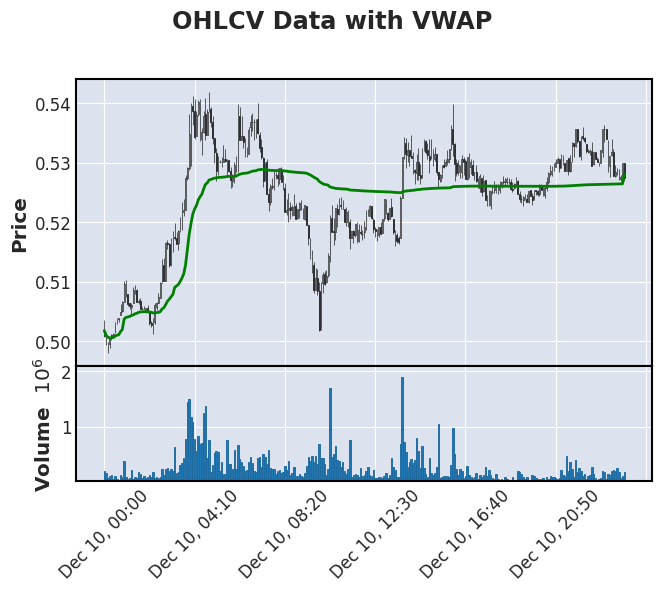

In [17]:
vwap_plot = mpf.make_addplot(df.loc["2023-12-10 00:00:00":"2023-12-11 00:00:00"]["VWAP"], type="line", color="green", width=2)
axlist = mpf.plot(df.loc["2023-12-10 00:00:00":"2023-12-11 00:00:00"], type='candle', volume=True, title='OHLCV Data with VWAP', addplot=vwap_plot)
plt.show()

In [18]:
class Order_Execution_Agent:

    def __init__(self, state_size, data, batch_size, inventory, model_name, learning_rate) -> None:
        """
        Initialises class 

        Parameters:
        - state_size (int): The size of each state.
        - data (pd.DataFrame): Data used for training our model
        - batch_size (int): The size of each batch.
        - inventory (int): Amount of inventory .
        - model_name (str): Name of the model.
        - learning_rate (float): Learning rate of the model.

        Returns:
        - None:
        """
        self.state_size = state_size # 9 states 
        self.data = data # Close price, Volume, VWAP, VWAP_std, Moving Average
        self.batch_size = batch_size
        self.action_size = 2 # Hold, Sell 
        self.inventory = inventory # Amount of tokens being held
        self.equal_selling_amount = self.inventory/288 
        self.gamma = 0.95
        self.epsilon = 0.5 # balanced between exploring hold/sell and exploiting learned strategies
        self.epsilon_min = 0.01 
        self.epsilon_decay = 0.822
        self.model_name = model_name    
        self.learning_rate = learning_rate
        self.usdt = 0
        self.memory = deque()
        self.model = self._model()


    def _model(self):
        """
        Initiates Neural Network model

        Returns:
        - model: Tensorflow Model
        """
        input_shape = (self.state_size,)
        inputs = tf.keras.Input(shape=input_shape)

        x = tf.keras.layers.Dense(20, activation="relu")(inputs)
        x = tf.keras.layers.Dense(20, activation="relu")(x)
        outputs = tf.keras.layers.Dense(self.action_size, activation="linear")(x)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss="mse") # Compiles modeel with Adam Optimizerand MSE loss

        return model


    def act(self, state):
        """
        From the given state an action is selected to prodceed to the next state

        Parameters:
        - state :  The state of the environment 

        Returns:
        - The function returns the action to execute 
        """

        # Epsilon greedy algorithm 
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size) # Random action is chosen 
        
        else:
            action_values = self.model.predict(state, verbose=0)
            return np.argmax(action_values[0]) # Action that gives the highest Q value 
    
    def sell_inventory_check(self, amount_to_sell):
        """
        Adjusts amount to sell based on left over inventory 

        Parameters:
        - amount_to_sell (float) :  Amount of inventory to sell

        Returns:
        - amount_to_sell (float) :  Aamount of inventory to sell after inventory check
        """

        if self.inventory - amount_to_sell< 0:
            amount_to_sell = self.inventory # if the amount to sell gives negative inventory we sell the remaining invetory to balance to 0 

        return amount_to_sell


    def take_action(self, action, state, t, end_of_day, initial_quantity, test):
        """
        Takes action to sell or hold. It also decideds if it should sell more or less than the constant amount based on market conditions 

        Parameters:
        - action (int) :  A number either being 0 or 1, 0 for hold and 1 for selling
        - state (np.darray) :  A numpy array containing information of the state the environment the agent is in 
        - t (Time) :  Current timestep of current trading day 
        - end_of_day (Time) :  Timestep of end of day 
        - initial_quantity (float) :  Initial quantity when agent started liquidating inventory 
        - test (int): A binary indicator to indicate if in test or training 

        Returns:
        - next_state (float) :  Aamount of inventory to sell after inventory check
        - reward (float): Positive or negative incentive based on actions
        - completed (int) : A binary indicator to indicate if trading day has ended or all inventory liquidated
        """

        reward = 0
        
        # action = 0 means to hold so we sell nothing
        if action == 0:
            inventory_ratio = self.inventory / initial_quantity
            amount_to_sell = 0*self.equal_selling_amount

            # Holding Reward function
            if state[0][6] == 1 and state[0][5] == 1:
                # positive reward for holding when market is trending and price above vwap, as in trending market assests continue to trend up in theory, although we give less rewards for holding if we haven't sold at least half
                reward += (state[0][0] - state[0][2]) * self.equal_selling_amount if inventory_ratio < 0.5 else ((state[0][0] - state[0][2]) * self.equal_selling_amount)/2
            elif state[0][6] == 0 and state[0][5] == 1:
                # penalise as market isn't trending but price is above the vwap. We should be selling as we can sell at good prices even without a trending market structure
                reward -= (state[0][0] - state[0][2]) * self.equal_selling_amount

            elif state[0][6]== 0 and state[0][5] == 0:
                # negative reward for holding when market isn't trending and price is below the vwap, as trending downwards market may indicate that further downside 
                reward -= (state[0][2] - state[0][0]) * self.equal_selling_amount

            else:
                reward = 0 # reward for holding under all other market conditions 
                
        # action = 1 means to sell 
        if action==1:

            if state[0][6] == 0 and state[0][5]==1:
                # we sell more as market isn't trending and price is above VWAP, we assume no reason for price to be where it is
                amount_to_sell = 1.35*self.equal_selling_amount

            elif state[0][6]==0 and state[0][5]==0:
                # we sell the set amount if market isn't trending and price is below the VWAP 
                amount_to_sell = self.equal_selling_amount

            elif state[0][6] == 1 and state[0][5] == 1:
                # Market is trending and price is above VWAP, so we would like to sell more now to allow us to sell at high prices
                amount_to_sell = 1.60*self.equal_selling_amount
            
            elif state[0][6] == 1 and state[0][5] == 0:
                # Market is trending and price is below VWAP, we expect price to keep rising however price < vwap could indicate trend is losing strength so we sell a bit more than usual 
                amount_to_sell = 1.15*self.equal_selling_amount

            # Makes sure we are not selling more inventory than we hold 
            amount_to_sell = self.sell_inventory_check(amount_to_sell)


            # Selling Reward mechanism 
            if state[0][0] > state[0][2] + state[0][3]:
                # reward because sold above vwap and its std
                reward+=( state[0][0] - (state[0][2] - state[0][3]) ) * amount_to_sell

            elif state[0][0] < state[0][2] - state[0][3]:
                # penalise because sold below vwap and its std
                reward -= ( (state[0][2] + state[0][3]) - state[0][0] ) * amount_to_sell

            elif state[0][2] + state[0][3] <= state[0][0] <= state[0][2] + state[0][3]:
                # reward because sold above inbetween vwap and its +-std
                reward += ( (state[0][2] + state[0][3]) - (state[0][2] - state[0][3]) ) * amount_to_sell

        self.inventory-=amount_to_sell

        if test == 1:
            new_row = pd.DataFrame([{"Execution_Price" : state[0][0], "Execution_Volume" : amount_to_sell}])
            self.execution_evaluation = pd.concat([self.execution_evaluation, new_row], ignore_index=True)

        total_amount_sold = initial_quantity - self.inventory
        inventory_reduction_reward =  (total_amount_sold/initial_quantity)*100 # rewards for reducing inventory, scales by 100 

        reward+=inventory_reduction_reward

        self.usdt += state[0][0]*amount_to_sell
        
        completed = 1 if t==end_of_day else 0

        if completed == 1:
            next_state = None
            
            if self.inventory>0:
                reward -= 200 # heavily penalised if more inventory left over
            elif self.inventory == 0:
                reward += 200

            
        
        if completed == 0:
            current_index_location = self.data.index.get_loc(t)
            next_state = self.get_state(self.data.index[current_index_location+1])

            if self.inventory==0:
                reward+=200
                completed = 1
                next_state = None

        return next_state, reward, completed 


    def get_state(self, t):
        """
        Computes the state of the agent at time 't'.

        Parameters:
        - t (time) : Current timestep of current trading day 

        Returns:
        - state (np.darray) : numpy array of current state 
        """
        close = self.data["Close"].loc[t]
        volume = self.data["Volume"].loc[t]
        vwap = self.data["VWAP"].loc[t] 
        try:
            vwap_std = self.data["VWAP_std"].loc[t] if not pd.isna(self.data["VWAP_std"].loc[t]) else 0
        except:
            print(self.data["VWAP_std"].loc[t])

        moving_average = self.data["EMA(5)"].loc[t] if not pd.isna(self.data["EMA(5)"].loc[t]) else close

        above_vwap = 1 if close > vwap else 0 # binary classifier: 1 for price above vwap 0 otherwise
        trending = 1 if close > moving_average else 0 # binary classifier: 1 if market is trending 0 otherwise

        state = np.array([close, volume, vwap, vwap_std, moving_average, above_vwap, trending, self.usdt, self.inventory])
        state = np.expand_dims(state, axis=0)
        return state


    def reset_state(self, initial_quantity):
        """ 
        Resets state 

        Parameters:
        - initial_quantity (float) : Initial quantity when agent started liquidating inventory 

        Returns:
        - None
        """
        self.inventory = initial_quantity
        self.usdt = 0
    

    def replay(self, batch_size): 
        """
        Replays from a batch of experiences of the agents memory to aid

        Parameters:
        - batch_size (int) : Batch size to collect from agents memory 

        Returns:
        - loss (float) : Loss from training model
        """

        mini_batch = random.sample(self.memory, min(len(self.memory), batch_size)) # Samples a batch of experiences from memory 

        states = np.zeros((batch_size, self.state_size))
        prediction_q = self.model.predict(states, verbose=0)  # Predicts Q value

        for i, (state, action, reward, next_state, completed) in enumerate(mini_batch):

            states[i] = state

            if not completed:
                future_reward = np.amax(self.model.predict(next_state, verbose=0)[0]) # Takes maximum Q value 
                target_q = reward + self.gamma*future_reward # Sets target Q value

            else:
                target_q = reward # Sets target Q value to reward if at final state as there is no Q value for next since at t=T 
            
            prediction_q[i][action] = target_q # Updates predicted q value for the state and action with the target q value


        history = self.model.fit(states, prediction_q, batch_size=batch_size, epochs=1, verbose=0) # Trains the model for 1 epochs 
        loss = history.history["loss"][0] # Loss from training the model 

        # Expotential epsilon decay 
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss
    

    def calculate_execution_price(self, trade_executions):
        """ 
        Calculates the VWAP of our execution

        Parameters:
        - trade_executions (pd.DataFrame) : Dataframe containing trades of executed prices and volume

        Returns:
        - VWAP (float) : VWAP of our execution 
        """

        return (trade_executions["Execution_Price"] * trade_executions["Execution_Volume"]).sum() / trade_executions["Execution_Volume"].sum()


    def train(self, iterations, checkpoint, initial_quantity):
        """
        Trains Deep Q Learning Model

        Parameters:
        - iterations : Amount of episodes to train the model 
        - checkpoint (int): When to check characteristics of the models performance  
        - initial_quantity (float): Initial quantity when agent started liquidating inventory 

        Returns:
        - rewards_per_iterations (list) : List of average reward per episode 
        """
        
        rewards_per_iterations = []

        for i in range(iterations):
            
            total_rewards = 0
            unique_dates = self.data.index.normalize().unique()


            for day in unique_dates:

                self.reset_state(initial_quantity)
                start_of_day = datetime.combine(day.date(), time.min)
                end_of_day = datetime.combine(day.date(), time(23,55))
                

                for t in pd.date_range(start=start_of_day, end=end_of_day, freq="5min", inclusive="right"):
                    state = self.get_state(t=t)
                    action = self.act(state=state)

                    next_state, reward, completed = self.take_action(action=action, state=state, t=t, end_of_day=end_of_day, initial_quantity=initial_quantity, test=0)                

                    total_rewards += reward 

                    if completed == 1:
                        self.memory.append((state, action, reward, None, completed)) # Adds experiences to memory 
                        break
                    else:
                        self.memory.append((state, action, reward, next_state, completed)) # Adds experiences to memory

                    state = next_state
                    
                    batch_size = min(self.batch_size, len(self.memory))
                    loss = self.replay(batch_size=batch_size)
            

                if (i+1) % checkpoint ==0:
                    print(f'Epoch: {i+1} | Day: {day} |Total rewards: {reward} | Loss: {loss} | Total Quantity Left: {self.inventory} | Total money {self.usdt}')
            
            
            average_reward = total_rewards / iterations
            rewards_per_iterations.append(average_reward)

        self.model.save(f"{self.model_name}.h5")

        return rewards_per_iterations


    
    def test(self, test_data, initial_quantity):
        """
        Test Deep Q Learning Model

        Parameters:
        - test_data : Test data to test our model
        - initial_quantity (float): Initial quantity when agent started liquidating inventory 

        Returns:
        - execution_vwaps (list) : VWAP of our execution 
        """

        self.data = test_data
        self.inventory = initial_quantity
        self.daily_inventory_levels = []
        self.hold = []
        self.sell = []
        self.usdt_each_day = []
        unique_dates = self.data.index.normalize().unique()

        columns = ["Execution_Price", "Execution_Volume"]
        self.execution_evaluation = pd.DataFrame(columns=columns)
        execution_vwaps = []

        for day in unique_dates:
 
            self.reset_state(initial_quantity)
            self.daily_inventory_levels.append(self.inventory)

            start_of_day = datetime.combine(day.date(), time.min)
                
            end_of_day = datetime.combine(day.date(), time(23,55))
                
            for t in pd.date_range(start=start_of_day, end=end_of_day, freq="5min", inclusive="right"):
                state = self.get_state(t=t)
                action = self.act(state=state)
                
                # Marks the time agent held or sold 
                if action == 0:
                    self.hold.append(t)
                elif action == 1:
                    self.sell.append(t)

                next_state, reward, completed = self.take_action(action=action, state=state, t=t, end_of_day=end_of_day, initial_quantity=initial_quantity, test=1)                
                self.daily_inventory_levels.append(self.inventory)
                if completed == 1:
                    execution_vwaps.append(self.calculate_execution_price(self.execution_evaluation))
                    break

            
            plt.figure(figsize=(10,4))
            plt.plot(self.daily_inventory_levels, label=f'Inventory On {day.date()}')
            plt.title(f'DQN Test Inventory Over Day: {day.date()}')
            plt.xlabel("Time Step")
            plt.ylabel("Inventory Amount")
            plt.legend()
            plt.savefig(f'test_images/dqn/inventory_reduction/inventory_{day.date()}.png')
            plt.close()

            daily_close = self.data["Close"].loc[start_of_day:end_of_day]

            hold_indices = [daily_close.index.get_loc(time) for time in self.hold if time in daily_close.index]
            sell_indices = [daily_close.index.get_loc(time) for time in self.sell if time in daily_close.index]

            daily_close = daily_close.values.tolist()
            
            plt.figure(figsize=(10,4))
            plt.plot(daily_close, label="Price", color="blue")
            plt.plot(daily_close, "o", markersize=4, label="Holding", color="orange", markevery = hold_indices)
            plt.plot(daily_close, "v", markersize=4, label="Selling", color="red", markevery = sell_indices)
            plt.title(f'DQN Test Actions Over Day: {day.date()}')
            plt.xlabel("Time Step")
            plt.ylabel("Price")
            plt.legend()
            plt.savefig(f'test_images/dqn/actions/actions_on_{day.date()}.png')
            plt.close()

            self.daily_inventory_levels = []
            self.hold = []
            self.sell = []
            self.usdt_each_day.append(self.usdt)
            self.execution_evaluation = pd.DataFrame(columns=columns)
        return execution_vwaps

In [19]:
training_data = df.loc["2023-12-01 00:00:00":"2023-12-07 23:55:00"]
agent = Order_Execution_Agent(state_size=9, data=training_data, batch_size=16, inventory=2000000, model_name="Order_Execution", learning_rate=0.05)
rewards_per_iterations = agent.train(iterations=15, checkpoint=1, initial_quantity=2000000)

Epoch: 1 | Day: 2023-12-01 00:00:00 |Total rewards: -168.8194444444446 | Loss: 7181.9873046875 | Total Quantity Left: 1376388.8888888918 | Total money 314101.8055555556
Epoch: 1 | Day: 2023-12-02 00:00:00 |Total rewards: -137.0412608718197 | Loss: 6361.435546875 | Total Quantity Left: 1977777.777777778 | Total money 11840.0
Epoch: 1 | Day: 2023-12-03 00:00:00 |Total rewards: -167.88194444444454 | Loss: 806.77392578125 | Total Quantity Left: 1357638.8888888909 | Total money 348226.4930555554
Epoch: 1 | Day: 2023-12-04 00:00:00 |Total rewards: -174.10046804708298 | Loss: 1996.927490234375 | Total Quantity Left: 1784722.222222223 | Total money 117091.25
Epoch: 1 | Day: 2023-12-05 00:00:00 |Total rewards: -189.21875000000006 | Loss: 3171.0263671875 | Total Quantity Left: 1784375.000000001 | Total money 117154.0625
Epoch: 1 | Day: 2023-12-06 00:00:00 |Total rewards: -190.43402777777786 | Loss: 2659.026611328125 | Total Quantity Left: 1808680.555555557 | Total money 99939.72222222222
Epoch: 

Epoch: 8 | Day: 2023-12-04 00:00:00 |Total rewards: 299.99999999997056 | Loss: 4041.1416015625 | Total Quantity Left: 0.0 | Total money 1092059.166666668
Epoch: 8 | Day: 2023-12-05 00:00:00 |Total rewards: 262.6820497713911 | Loss: 2059.34716796875 | Total Quantity Left: 0.0 | Total money 1079655.000000001
Epoch: 8 | Day: 2023-12-06 00:00:00 |Total rewards: 231.8987003618683 | Loss: 4730.66943359375 | Total Quantity Left: 0.0 | Total money 1031201.7361111115
Epoch: 8 | Day: 2023-12-07 00:00:00 |Total rewards: 357.64179678170035 | Loss: 3701.234130859375 | Total Quantity Left: 0.0 | Total money 979672.3611111109
Epoch: 9 | Day: 2023-12-01 00:00:00 |Total rewards: 278.1418426156691 | Loss: 3094.2080078125 | Total Quantity Left: 0.0 | Total money 1010742.1180555568
Epoch: 9 | Day: 2023-12-02 00:00:00 |Total rewards: 448.4668525772815 | Loss: 3065.95166015625 | Total Quantity Left: 0.0 | Total money 1024303.5763888904
Epoch: 9 | Day: 2023-12-03 00:00:00 |Total rewards: 200.15928560390364 |

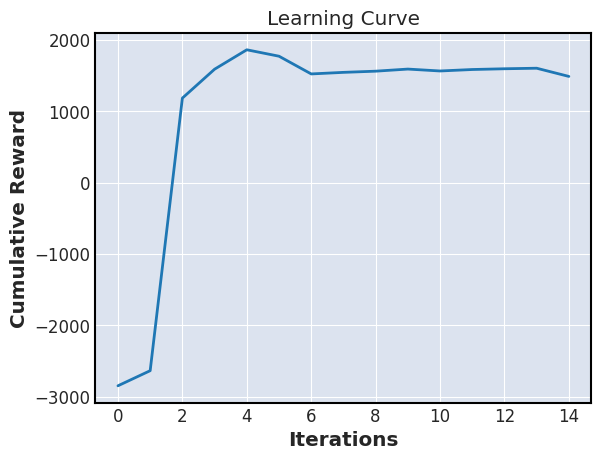

In [20]:
plt.plot(rewards_per_iterations)
plt.title("Learning Curve")
plt.ylabel("Cumulative Reward")
plt.xlabel("Iterations")
plt.savefig("test_images/dqn/learning_curve.png")
plt.show()

In [34]:
testing_data = df.loc["2023-12-20 00:00:00":"2023-12-27 23:55:00"]
dqn_execution = agent.test(test_data=testing_data, initial_quantity=2000000)

In [35]:
class baseline_agent:
    def __init__(self, data, inventory) -> None:
        """
        Initialises class 

        Parameters:
        - data (pd.DataFrame): Data used for executing trades for our baseline model
        - inventory (int): Amount of inventory .

        Returns:
        - None:
        """
        self.data = data
        self.inventory =  inventory
        self.equal_selling_amount = self.inventory/288
        self.usdt = 0

    def calculate_execution_price(self, trade_executions:pd.DataFrame):
        return (trade_executions["Execution_Price"] * trade_executions["Execution_Volume"]).sum() / trade_executions["Execution_Volume"].sum()
    
        
    def baseline_vwap(self, test_data, initial_quantity):
        """ 
        Liquidates inventory based on VWAP algorithm strategy

        Parameters:
        - test_data (pd.DataFrame): Data used for executing trades for our baseline model
        - initial_quantity (int): Initial amount of inventory .

        Returns:
        - execution_vwaps (list) : VWAP of our execution 

        """
        self.data = test_data
        self.inventory = initial_quantity
        self.daily_inventory_levels = []
        self.hold = []
        self.sell = []
        self.usdt_each_day = []


        columns = ["Execution_Price", "Execution_Volume"]
        self.execution_evaluation = pd.DataFrame(columns=columns)
        execution_vwaps = []
        
        unique_dates = self.data.index.normalize().unique()
        
        for day in unique_dates:
            
            self.inventory = initial_quantity
            self.usdt = 0
            
            self.daily_inventory_levels.append(self.inventory)

            start_of_day = datetime.combine(day.date(), time.min)
                
            end_of_day = datetime.combine(day.date(), time(23,55))

            for t in pd.date_range(start=start_of_day, end=end_of_day, freq="5min", inclusive="right"):
                
                if self.data["Close"].loc[t] >= self.data["VWAP"].loc[t]:
                    
                    amount_to_sell = 1.1*self.equal_selling_amount # Sell more than base amount if price is above the VWAP

                else:
                    amount_to_sell = self.equal_selling_amount
                
                amount_to_sell = min(amount_to_sell, self.inventory) # Ensures we are not selling more than our current inventory 
                
                self.sell.append(t)

                self.inventory-=amount_to_sell


                new_row = pd.DataFrame([{"Execution_Price" : self.data["Close"].loc[t], "Execution_Volume" : amount_to_sell}])
                self.execution_evaluation = pd.concat([self.execution_evaluation, new_row], ignore_index=True)

                self.usdt += self.data["Close"].loc[t]*amount_to_sell
        
                completed = 1 if t==end_of_day else 0
   
                if completed == 0 and self.inventory==0:
                    completed = 1

                self.daily_inventory_levels.append(self.inventory)
                
                if completed == 1:
                    execution_vwaps.append(self.calculate_execution_price(self.execution_evaluation))
                    break

            
            plt.figure(figsize=(10,4))
            plt.plot(self.daily_inventory_levels, label=f'Inventory On {day.date()}')
            plt.title(f'Baseline VWAP Inventory Over Day: {day.date()}')
            plt.xlabel("Time Step")
            plt.ylabel("Inventory Amount")
            plt.legend()
            plt.savefig(f'test_images/baseline/inventory_reduction/inventory_{day.date()}.png')
            plt.close()

            daily_close = self.data["Close"].loc[start_of_day:end_of_day]

            hold_indices = [daily_close.index.get_loc(time) for time in self.hold if time in daily_close.index]
            sell_indices = [daily_close.index.get_loc(time) for time in self.sell if time in daily_close.index]

            daily_close = daily_close.values.tolist()
            
            plt.figure(figsize=(10,4))
            plt.plot(daily_close, label="Price", color="blue")
            plt.plot(daily_close, "o", markersize=4, label="Holding", color="orange", markevery = hold_indices)
            plt.plot(daily_close, "v", markersize=4, label="Selling", color="red", markevery = sell_indices)
            plt.title(f'Baseline VWAP Actions Over Day: {day.date()}')
            plt.xlabel("Time Step")
            plt.ylabel("Price")
            plt.legend()
            plt.savefig(f'test_images/baseline/actions/actions_on_{day.date()}.png')
            plt.close()

            self.daily_inventory_levels = []
            self.hold = []
            self.sell = []
            self.usdt_each_day.append(self.usdt)
            self.execution_evaluation = pd.DataFrame(columns=columns)

        return execution_vwaps               

In [36]:
base_agent = baseline_agent(data= testing_data, inventory=2000000)
base_execution = base_agent.baseline_vwap(test_data=testing_data, initial_quantity=2000000)

In [37]:
class market_agent:
    
    def __init__(self, data) -> None:
        """
        Initialises class 

        Parameters:
        - data (pd.DataFrame): Data used for executing trades for our benchmark model

        Returns:
        - None:
        """

        self.data = data

    
    def baseline_vwap(self, test_data):
        """
        Records VWAP prices for liquidation events  

        Parameters:
        - test_data (pd.DataFrame): Data used for executing trades for our benchmark model

        Returns:
        - execution_vwaps (list) : VWAP of our execution 
        """
        self.data = test_data
        execution_vwaps = []
        
        unique_dates = self.data.index.normalize().unique()
        
        for day in unique_dates:
            
            start_of_day = datetime.combine(day.date(), time.min)
                
            end_of_day = datetime.combine(day.date(), time(23,55))

            for t in pd.date_range(start=start_of_day, end=end_of_day, freq="5min", inclusive="right"):
                
                completed = 1 if t==end_of_day else 0
                   
                if completed == 1:
                    execution_vwaps.append(self.data["VWAP"].loc[t])
                    break
        return execution_vwaps


In [38]:
market_benchmark_agent = market_agent(data= testing_data)
market_execution = market_benchmark_agent.baseline_vwap(test_data=testing_data)

In [39]:
def compare_efficiency(model_execution, market_execution):
    # Gets the efficiency of our model to the benchmark execution (VWAP)
    model_execution = np.array(model_execution)
    market_execution = np.array(market_execution)

    effeciency = model_execution - market_execution
    return effeciency

In [40]:
base_execution_efficiency = compare_efficiency(base_execution, market_execution)
print(base_execution_efficiency)

[-0.00051775 -0.00317898 -0.0022369  -0.00182196  0.0007006  -0.00102277
  0.00221056  0.00056122]


In [41]:
dqn_execution_efficiency = compare_efficiency(dqn_execution, market_execution)
print(dqn_execution_efficiency)

[-0.00054514 -0.00047224 -0.00173796 -0.00036803  0.00188978 -0.00137359
  0.00338201  0.00060791]


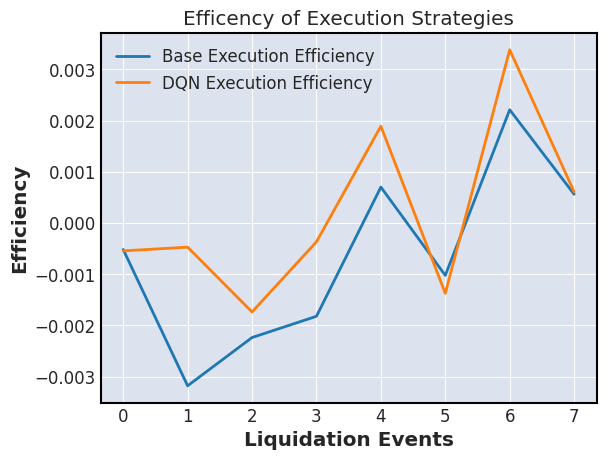

In [42]:
plt.plot(base_execution_efficiency, label="Base Execution Efficiency")
plt.plot(dqn_execution_efficiency, label="DQN Execution Efficiency")
plt.ylabel("Efficiency")
plt.xlabel("Liquidation Events")
plt.title("Efficency of Execution Strategies")
plt.legend()
plt.show()

Execution Statistics

In [43]:
average_dqn_execution_efficiency = np.mean(dqn_execution_efficiency)
median_dqn_execution_efficiency = np.median(dqn_execution_efficiency)
std_dqn_execution_efficiency = np.std(dqn_execution_efficiency)
percentiles_dqn_execution_efficiency = np.percentile(dqn_execution_efficiency, [25, 50, 75])
print("Average DQN Efficiency:", average_dqn_execution_efficiency, "Median DQN Efficiency:", median_dqn_execution_efficiency, "Std DQN Efficiency:", std_dqn_execution_efficiency, "Percentiles DQN Efficiency:",percentiles_dqn_execution_efficiency)

Average DQN Efficiency: 0.0001728420732783828 Median DQN Efficiency: -0.0004201362221545324 Std DQN Efficiency: 0.0016086779962025044 Percentiles DQN Efficiency: [-0.00075225 -0.00042014  0.00092838]


In [44]:
average_base_execution_efficiency = np.mean(base_execution_efficiency)
median_base_execution_efficiency = np.median(base_execution_efficiency)
std_base_execution_efficiency = np.std(base_execution_efficiency)
percentiles_base_execution_efficiency = np.percentile(base_execution_efficiency, [25, 50, 75])
print("Average Base Efficiency:", average_base_execution_efficiency, "Median Base Efficiency:", median_base_execution_efficiency, "Std Base Efficiency:", std_base_execution_efficiency, "Percentiles Base Efficiency:",percentiles_base_execution_efficiency)

Average Base Efficiency: -0.0006632473364438715 Median Base Efficiency: -0.0007702601532800779 Std Base Efficiency: 0.00165516124983966 Percentiles Base Efficiency: [-0.00192569 -0.00077026  0.00059607]


In [45]:
_, p_value_normaltest_dqn_execution = stats.shapiro(dqn_execution_efficiency)
_, p_value_normaltest_base_execution = stats.shapiro(base_execution_efficiency)

In [47]:
if p_value_normaltest_dqn_execution > 0.05 and p_value_normaltest_base_execution > 0.05:
    
    _, p_value_ttest = stats.ttest_ind(dqn_execution_efficiency, base_execution_efficiency)
    print("Both execution models follow a normal distribution")
    if p_value_ttest <= 0.05:
        
        print(f"The difference in performance is statistically significant (p-value: {p_value_ttest})")
    else:
        print(f"There is no statistically significant difference in performance (p-value: {p_value_ttest})")
        
else:
    _, p_value_mannwhitney = stats.mannwhitneyu(dqn_execution_efficiency, base_execution_efficiency)
    print("One or both of the execution models do not follow a normal distribution")
    if p_value_mannwhitney <= 0.05:
        
        print(f"The difference in performance is statistically significant (p-value: {p_value_mannwhitney})")
    else:
        print(f"There is no statistically significant difference in performance (p-value: {p_value_mannwhitney})")

Both execution models follow a normal distribution
There is no statistically significant difference in performance (p-value: 0.3541238015089576)
